In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr

In [2]:


# Load datasets and prepare data
normal_input = xr.open_dataset('/home/egauillard/extreme_events_forecasting/notebooks/test/input_unscaled.nc')
coarse_input = xr.open_dataset('/home/egauillard/extreme_events_forecasting/notebooks/test/coarse_dataset.nc')
fine_input = xr.open_dataset('/home/egauillard/extreme_events_forecasting/notebooks/test/fine_dataset.nc')
coarse_t_fine_s = xr.open_dataset('/home/egauillard/extreme_events_forecasting/notebooks/test/coarse_t_fine_s_dataset.nc')


In [4]:
std = xr.open_dataset("/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/statistics/std_1940-2005_10-11-12-1-2-3_msl_sst_stream_north_hemisphere_1deg_7days_sum_pr.nc")
mean = xr.open_dataset("/home/egauillard/extreme_events_forecasting/earthfomer_mediteranean/src/statistics/mean_1940-2005_10-11-12-1-2-3_msl_sst_stream_north_hemisphere_1deg_7days_sum_pr.nc")

In [9]:
std.msl.values

array([[[ 243.25005,  247.95474,  243.61157, ...,  237.0084 ,
          237.18552,  239.28238],
        [ 241.35173,  245.63177,  238.77516, ...,  228.5308 ,
          230.31676,  234.57172],
        [ 242.6685 ,  245.20302,  235.73294, ...,  222.05783,
          224.5747 ,  232.2654 ],
        ...,
        [1014.7069 , 1013.40826, 1012.1251 , ..., 1018.68225,
         1017.359  , 1016.03674],
        [ 998.8942 ,  998.2094 ,  997.51294, ..., 1000.9912 ,
         1000.2867 ,  999.5655 ],
        [ 987.2205 ,  987.0544 ,  986.8391 , ...,  987.89636,
          987.6839 ,  987.47235]],

       [[ 246.11118,  249.41965,  243.07689, ...,  240.9278 ,
          241.26753,  243.01843],
        [ 248.01895,  249.17583,  239.11154, ...,  235.67091,
          237.85558,  242.08011],
        [ 253.81932,  250.13829,  236.79941, ...,  235.07774,
          239.01797,  246.5921 ],
        ...,
        [ 996.3873 ,  994.94727,  993.5234 , ..., 1000.74524,
          999.302  ,  997.8533 ],
        [ 97

In [7]:
list(fine_input.data_vars)

['stream', 'msl', 'sst', 'tp', 't2m', 'ttr', 'wet_season_year']

KeyboardInterrupt: 

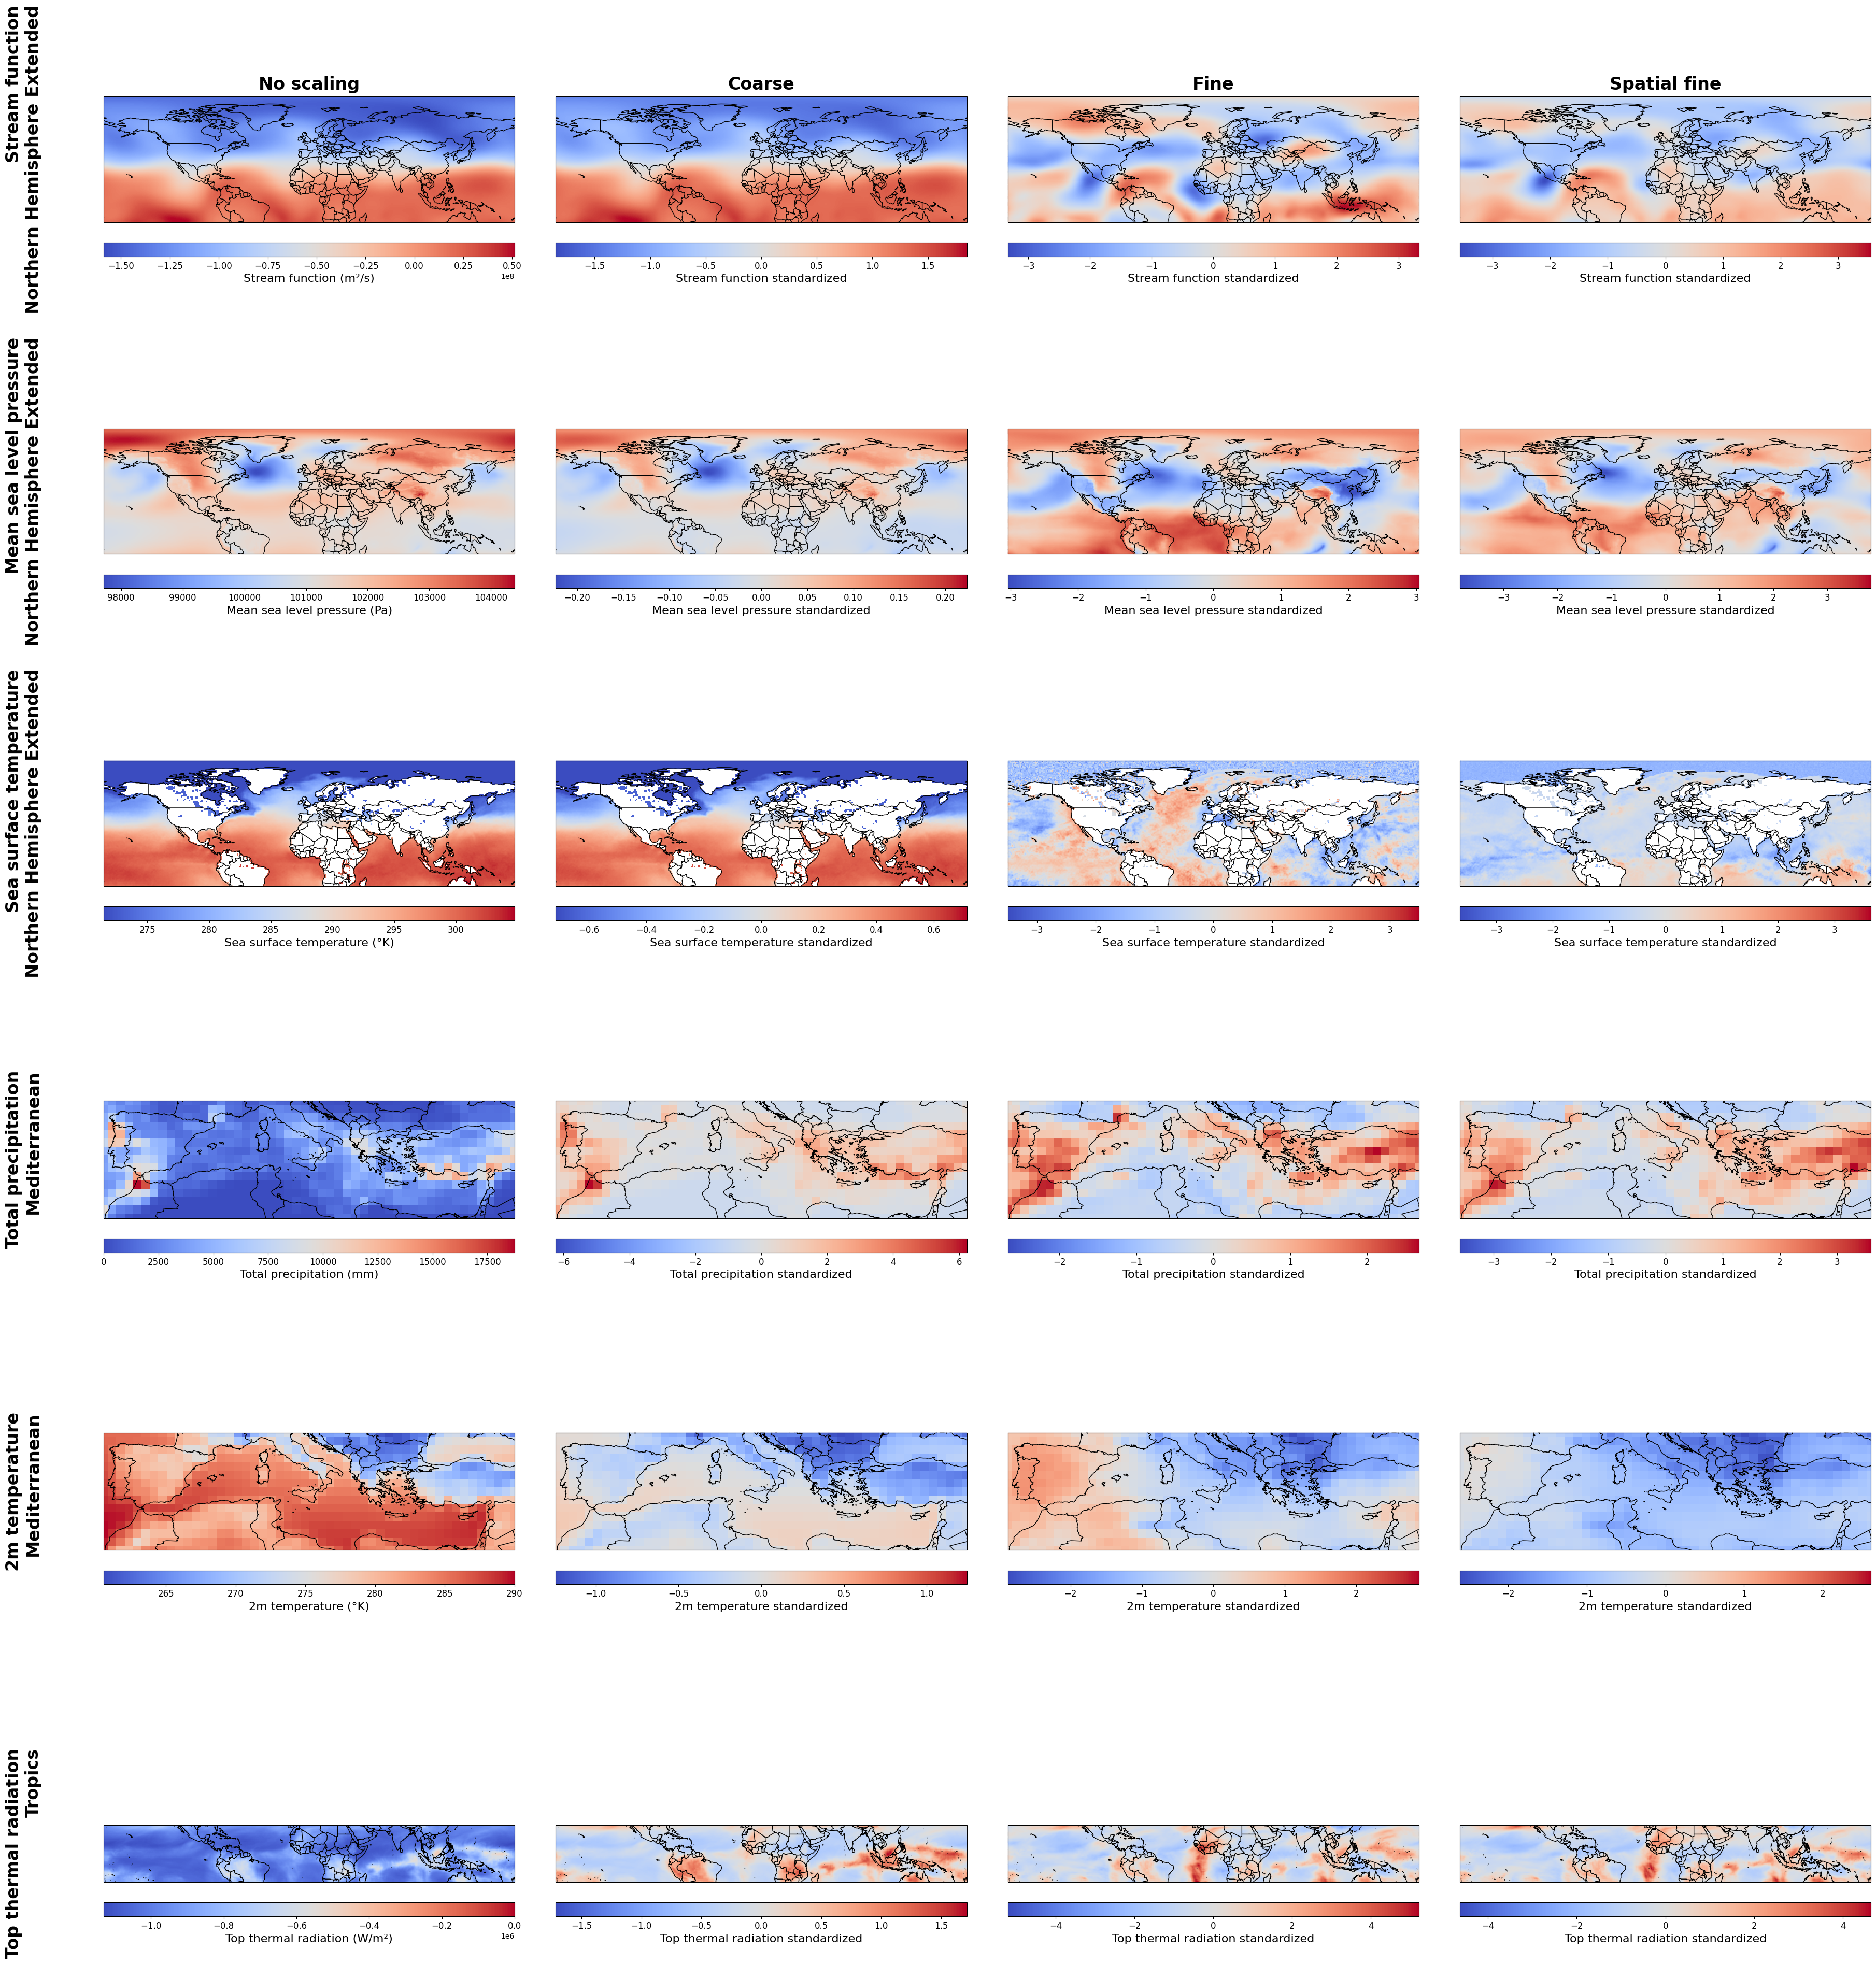

In [4]:
normal_input["tp"] = 1000 * normal_input["tp"]
datasets = [normal_input, coarse_input, fine_input, coarse_t_fine_s]
dataset_labels = ["No scaling", "Coarse", "Fine", "Spatial fine"]

variables = ['stream', 'msl', 'sst', 'tp', 't2m', 'ttr']

# Set up the plot
n_datasets = len(datasets)
n_vars = len(variables)

fig = plt.figure(figsize=(11*n_datasets, 8*n_vars))

# Define the extents and units for each variable
var_info = {
    "t2m": {"extent": [-10, 39, 31, 45], "units": "°K", "region": "Mediterranean", "full_name": "2m temperature"},
    "tp": {"extent": [-10, 39, 31, 45], "units": "mm", "region": "Mediterranean", "full_name": "Total precipitation"},
    "ttr": {"extent": [-180, 180, -20, 30], "units": "W/m²", "region": "Tropics", "full_name": "Top thermal radiation"},
    "stream": {"extent": [-180, 180, -20, 90], "units": "m²/s", "region": "Northern Hemisphere Extended", "full_name": "Stream function"},
    "sst": {"extent": [-180, 180, -20, 90], "units": "°K", "region": "Northern Hemisphere Extended", "full_name": "Sea surface temperature"},
    "msl": {"extent": [-180, 180, -20, 90], "units": "Pa", "region": "Northern Hemisphere Extended", "full_name": "Mean sea level pressure"},
}

# Create grid for subplots with reduced spacing
grid = fig.add_gridspec(n_vars, n_datasets, hspace=0.3, wspace=0.1)

for row, var in enumerate(variables):
    for col, (ds, label) in enumerate(zip(datasets, dataset_labels)):
        ax = fig.add_subplot(grid[row, col], projection=ccrs.PlateCarree())
        
        data = ds[var].isel(time=0)
        
        if label == "No scaling":
            data = data.sel(latitude=slice(var_info[var]["extent"][2], var_info[var]["extent"][3]), 
                            longitude=slice(var_info[var]["extent"][0], var_info[var]["extent"][1]))
            vmin, vmax = data.min(), data.max()
        else:
            max_abs_val = max(abs(data.min()), abs(data.max()))
            vmin, vmax = -max_abs_val, max_abs_val
        
        im = ax.pcolormesh(data.longitude, data.latitude, data, 
                           transform=ccrs.PlateCarree(), 
                           cmap='coolwarm',
                           vmin=vmin, vmax=vmax)
        
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        
        ax.set_extent(var_info[var]["extent"], crs=ccrs.PlateCarree())
        
        cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
        if label == "No scaling":
            cbar.set_label(f'{var_info[var]["full_name"]} ({var_info[var]["units"]})', fontsize=16)
        else:
            cbar.set_label(f'{var_info[var]["full_name"]} standardized', fontsize=16)
        cbar.ax.tick_params(labelsize=12)
        
        if row == 0:
            ax.set_title(label, fontsize=24, fontweight='bold', pad=10)
        if col == 0:
            ax.text(-0.15, 0.5, f'{var_info[var]["full_name"]}\n{var_info[var]["region"]}', va='center', ha='right', rotation='vertical', 
                    transform=ax.transAxes, fontsize=24, fontweight='bold')

plt.savefig('input_data_visualization_regions_inverted.png', dpi=300, bbox_inches='tight')
plt.close()

In [19]:
# plot with cartopy and matplotlib
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-10, 39, 31, 45], crs=ccrs.PlateCarree())



1.1379907

In [35]:
med_t2m_fine.values

array([[[ 1.        ,  1.        ,  1.0000231 , ...,  1.        ,
          1.        , -1.        ],
        [ 1.        ,  1.        ,  1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 1.00001   ,  1.0000085 ,  1.0000058 , ..., -1.        ,
          1.000122  ,  0.9988074 ],
        ...,
        [ 0.999993  ,  1.0000048 ,  1.0000036 , ..., -0.99999386,
         -0.99999404, -1.        ],
        [ 0.9999929 ,  1.        ,  0.9999945 , ..., -1.        ,
         -1.        , -0.99999535],
        [ 0.9999931 ,  1.        ,  1.        , ..., -0.99999213,
         -1.0000051 , -1.0000037 ]],

       [[ 1.        ,  1.        ,  1.        , ..., -0.99996185,
         -1.0000263 , -1.        ],
        [ 0.99999034,  1.0000067 ,  1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 1.        ,  1.0000081 ,  0.9999942 , ..., -0.99996984,
         -0.99995077, -0.9999686 ],
        ...,
        [ 1.        ,  1.0000042 ,  1.        , ..., -